In [1]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
from sklearn.neighbors import KDTree
import tsfresh as ts 
import matplotlib.pyplot as plt 
from sklearn.linear_model import Ridge
import numpy as np
import pymc
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute


files = pd.read_excel('/home/velaraptor/Downloads/Raw Data 10yrs (2018).xlsx', header=1)

In [2]:
files = files.fillna(0)
groups = files.groupby('Name')

import tqdm

forecast_df = []
for name, group in tqdm.tqdm(groups):
    if len(group) > 1:
        group.index = group.Year
        df_shift, y = make_forecasting_frame(group["FantPt"], kind=name, max_timeshift=10, rolling_direction=1)
        forecast_df.append(df_shift)

100%|██████████| 2011/2011 [01:18<00:00, 24.86it/s]


In [3]:
f = files[files['Year'] != 2018]

test_f = files[files['Year'] ==2018].Name.unique()

test_ff = files[files['Name'].isin(test_f)]

In [4]:
for i in np.arange(2013, 2018, 1):
    print(i)

2013
2014
2015
2016
2017


In [6]:
training = []
for i in np.arange(2013, 2018, 1):
    files_temp = files[files['Year'] < i]
    extracted_features = extract_features(files_temp[['Year', 'Name', 'PPG', 'FantPt']], column_id="Name", column_sort="Year", default_fc_parameters=EfficientFCParameters())
    t_temp = extracted_features.reset_index()
    
    extracted_features = extracted_features.merge(files[(files['Year']==i)][['Name', 'Age', 'FantPt']], right_on='Name', left_on='id')
    extracted_features = extracted_features.dropna(subset=['FantPt'])
    ts_features = extracted_features.reset_index(drop=True)
    training.append(extracted_features)
    

training_df = pd.concat(training)
training_df = training_df.reset_index(drop=True)
ts_features = training_df.dropna(axis=1)



Feature Extraction: 100%|██████████| 20/20 [01:13<00:00,  2.02s/it]


In [7]:
test_features = extract_features(test_ff[['Year', 'Name', 'PPG', 'FantPt']], column_id="Name", column_sort="Year", default_fc_parameters=EfficientFCParameters())

Feature Extraction: 100%|██████████| 20/20 [00:27<00:00,  1.03it/s]


In [9]:
ts_features_test = test_features.reset_index()
ts_features_test = ts_features_test.dropna(axis=1)

In [22]:
columns = np.append(ts_features.columns[2:len(ts_features.columns)-3].values, 'Age')
ada = AdaBoostRegressor(base_estimator=GradientBoostingRegressor(loss='lad', max_depth=10, n_estimators=20, alpha=0.985), n_estimators=5, loss='exponential')
ada.fit(ts_features[columns], ts_features['FantPt'])

AdaBoostRegressor(base_estimator=GradientBoostingRegressor(alpha=0.985,
                                                           criterion='friedman_mse',
                                                           init=None,
                                                           learning_rate=0.1,
                                                           loss='lad',
                                                           max_depth=10,
                                                           max_features=None,
                                                           max_leaf_nodes=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=2,
                                                           min_w

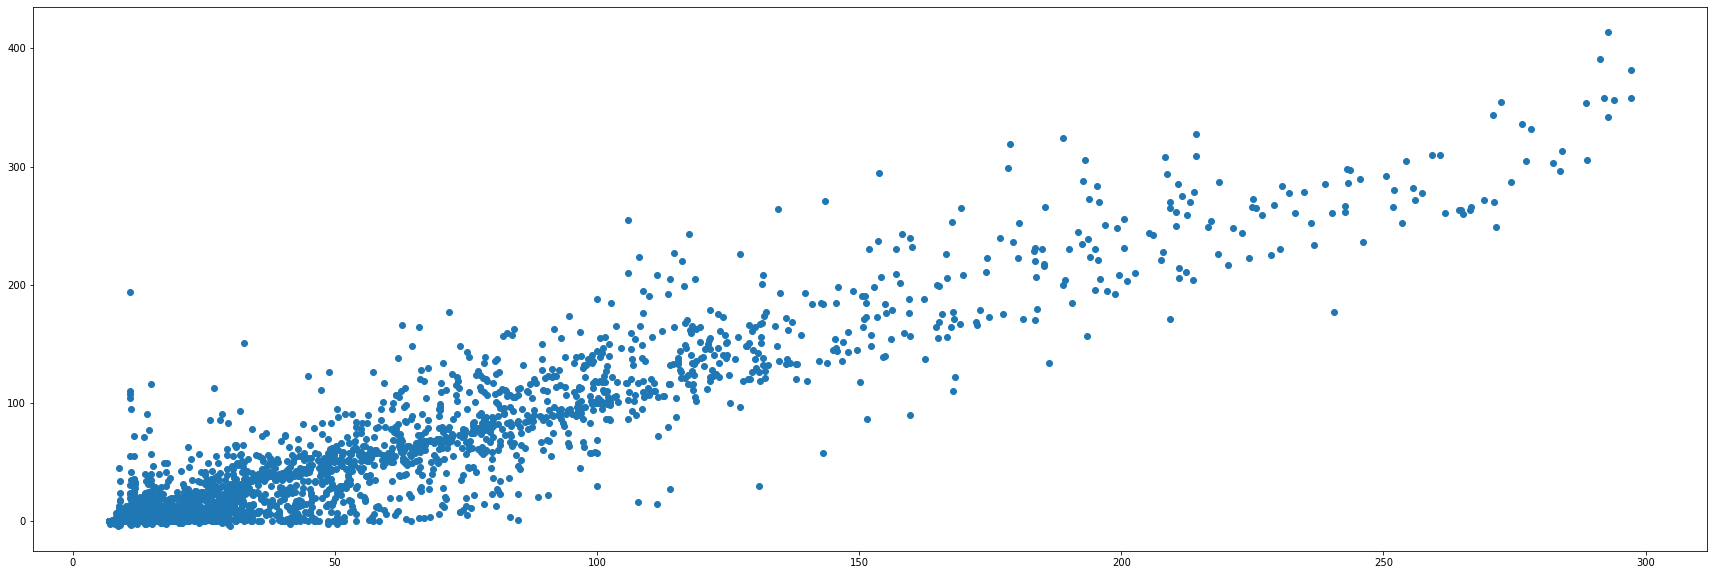

In [23]:
fig, ax = plt.subplots(figsize=(30,10))
plt.scatter(ada.predict(ts_features[columns]), ts_features['FantPt'])
plt.show()

In [24]:
pd.DataFrame([ada.predict(ts_features[columns]), ts_features['FantPt']]).T

,0,1
0,157.059070,209.0
1,11.651836,14.0
2,209.347843,171.0
3,189.354159,204.0
4,10.946897,0.0
5,74.047916,35.0
6,45.067432,48.0
7,27.290890,4.0
8,167.650018,253.0
9,32.326158,7.0


In [25]:
from sklearn.metrics import median_absolute_error
median_absolute_error(ts_features['FantPt'], ada.predict(ts_features[columns]))

13.000989943446534

In [30]:
ts_features_test['Age'] = ts_features_test.Age_x

In [31]:
# ts_features_test = ts_features_test.merge(files[(files['Year']==2018)][['Name', 'Age', 'FantPt']], right_on='Name', left_on='id')
final_predictions = pd.DataFrame({'Name': ts_features_test.id, 'prediction': ada.predict(ts_features_test[columns])})



In [32]:
final_predictions = final_predictions.merge(files[['Name', 'FantPos']].drop_duplicates(), on='Name', how='right').drop_duplicates('Name')

In [33]:
final_predictions.max()

Name          Zurlon Tipton
prediction          239.732
dtype: object

In [34]:
idx_1 = final_predictions.groupby(['FantPos'])['prediction'].transform(max) == final_predictions['prediction']

final_predictions[idx_1]

,Name,prediction,FantPos
69,Blake Bortles,239.732333,QB
101,Calvin Ridley,164.708979,WR
111,Case Keenum,157.591834,0
167,Dallas Goedert,135.995633,TE
422,Kareem Hunt,203.006991,RB


In [41]:
final_predictions_1 = final_predictions[~np.isnan(final_predictions['prediction'])]

In [45]:
final_predictions_1[final_predictions_1['FantPos'] ==  'QB'].sort_values('prediction', ascending=False).values

array([['Blake Bortles', 239.73233315745367, 'QB'],
       ['Matthew Stafford', 239.38371577897726, 'QB'],
       ['Russell Wilson', 230.61192926582353, 'QB'],
       ['Tom Brady', 225.88579086582354, 'QB'],
       ['Jameis Winston', 225.24025706108853, 'QB'],
       ['Marcus Mariota', 224.34914060134406, 'QB'],
       ['Derek Carr', 220.4061182910601, 'QB'],
       ['Cam Newton', 219.12499094922956, 'QB'],
       ['Philip Rivers', 215.51522353521034, 'QB'],
       ['Andy Dalton', 211.2528797464997, 'QB'],
       ['Josh Allen', 202.9413267600497, 'QB'],
       ['Matt Ryan', 200.6340301920395, 'QB'],
       ['Kirk Cousins', 198.8943439305312, 'QB'],
       ['Carson Wentz', 198.37499482454294, 'QB'],
       ['Andrew Luck', 192.65457810712357, 'QB'],
       ['Drew Brees', 186.8161510787297, 'QB'],
       ['Ben Roethlisberger', 184.96929236420596, 'QB'],
       ['Eli Manning', 183.04354824783803, 'QB'],
       ['Aaron Rodgers', 176.7559390287297, 'QB'],
       ['Jeff Driskel', 162.39845701

In [46]:
final_predictions_1[final_predictions_1['FantPos'] ==  'RB'].sort_values('prediction', ascending=False).values

array([['Kareem Hunt', 203.0069906672112, 'RB'],
       ['Nick Chubb', 165.0135641786369, 'RB'],
       ['Phillip Lindsay', 163.3181892486054, 'RB'],
       ['Gus Edwards', 159.09785701848196, 'RB'],
       ['Derrick Henry', 157.80543532594365, 'RB'],
       ['Sony Michel', 156.34587245491235, 'RB'],
       ['Kenyan Drake', 152.9689093326766, 'RB'],
       ['Mark Ingram', 152.29072688337976, 'RB'],
       ['Lamar Miller', 151.37670848220088, 'RB'],
       ['Alvin Kamara', 145.57692229746291, 'RB'],
       ['Jamaal Williams', 141.41318265976605, 'RB'],
       ['Aaron Jones', 140.8299836219286, 'RB'],
       ['Ezekiel Elliott', 140.09145672353716, 'RB'],
       ['Latavius Murray', 137.61322814061822, 'RB'],
       ['Jalen Richard', 135.00424371865773, 'RB'],
       ['LeSean McCoy', 134.76303876502777, 'RB'],
       ['Elijah McGuire', 134.05424830939785, 'RB'],
       ['Tevin Coleman', 133.28141724915181, 'RB'],
       ['Ito Smith', 131.95412170089142, 'RB'],
       ['Duke Johnson', 129.5

In [47]:
final_predictions_1[final_predictions_1['FantPos'] ==  'WR'].sort_values('prediction', ascending=False).values

array([['Calvin Ridley', 164.70897942385236, 'WR'],
       ['Anthony Miller', 159.09785701848196, 'WR'],
       ['Courtland Sutton', 159.09785701848196, 'WR'],
       ['A.J. Green', 150.0988224256255, 'WR'],
       ['Brandin Cooks', 145.9701072778565, 'WR'],
       ['Dede Westbrook', 143.94076901076045, 'WR'],
       ['Jordy Nelson', 141.40593427814684, 'WR'],
       ['Kenny Golladay', 140.8299836219286, 'WR'],
       ['Jarvis Landry', 139.8930983049036, 'WR'],
       ['Zay Jones', 134.3398252772951, 'WR'],
       ['DeAndre Hopkins', 134.23168011860542, 'WR'],
       ['Curtis Samuel', 133.15166822224074, 'WR'],
       ['Chris Godwin', 132.16651868224864, 'WR'],
       ['Cooper Kupp', 131.12263627205607, 'WR'],
       ['Odell Beckham', 130.9161401709987, 'WR'],
       ['Seth Roberts', 130.80866650681583, 'WR'],
       ['Albert Wilson', 130.16990441127834, 'WR'],
       ['Josh Reynolds', 129.4346954022927, 'WR'],
       ['Christian Kirk', 128.82077510288198, 'WR'],
       ['D.J. Moore', 

In [48]:
final_predictions_1[final_predictions_1['FantPos'] ==  'TE'].sort_values('prediction', ascending=False).values

array([['Dallas Goedert', 135.99563313182963, 'TE'],
       ['Alex Smith', 126.53103548387104, 'TE'],
       ['Ricky Seals-Jones', 125.00117369238886, 'TE'],
       ['Jordan Thomas', 119.69502740269142, 'TE'],
       ['Ian Thomas', 119.69502740269142, 'TE'],
       ['Cameron Brate', 119.44778835363681, 'TE'],
       ['Jack Doyle', 116.026847508887, 'TE'],
       ['Erik Swoope', 114.7780196923889, 'TE'],
       ['Blake Jarwin', 112.71270285344714, 'TE'],
       ['Jason Croom', 111.27988630214523, 'TE'],
       ['Anthony Firkser', 110.88622201067152, 'TE'],
       ["James O'Shaughnessy", 110.21058867251128, 'TE'],
       ['O.J. Howard', 108.99307958205847, 'TE'],
       ['Zach Ertz', 108.93012711835725, 'TE'],
       ['Gerald Everett', 108.92916565345844, 'TE'],
       ['MyCole Pruitt', 107.37988009989216, 'TE'],
       ['Chris Herndon', 105.32021836087169, 'TE'],
       ['Jimmy Graham', 103.28305976198477, 'TE'],
       ['Jesse James', 101.05360476617817, 'TE'],
       ['Evan Engram', 1

In [54]:
files[files['Name']=='Odell Beckham']['FantPt']

3604    204.0
4514    223.0
5110    196.0
5803     53.0
6118    153.0
Name: FantPt, dtype: float64

In [55]:
final_predictions_1[final_predictions_1['Name']=='Odell Beckham']['prediction']

565    130.91614
Name: prediction, dtype: float64

In [58]:
tree = KDTree(ts_features[columns])

In [88]:
ts_features_test.columns

Index(['id', 'FantPt__abs_energy', 'FantPt__absolute_sum_of_changes',
       'FantPt__agg_autocorrelation__f_agg_"mean"__maxlag_40',
       'FantPt__agg_autocorrelation__f_agg_"median"__maxlag_40',
       'FantPt__agg_autocorrelation__f_agg_"var"__maxlag_40',
       'FantPt__binned_entropy__max_bins_10', 'FantPt__c3__lag_1',
       'FantPt__c3__lag_2', 'FantPt__c3__lag_3',
       ...
       'PPG__value_count__value_1', 'PPG__variance',
       'PPG__variance_larger_than_standard_deviation', 'Name_x', 'Age_x',
       'FantPt_x', 'Name_y', 'Age_y', 'FantPt_y', 'Age'],
      dtype='object', length=470)

In [76]:
dist, ind = tree.query(ts_features_test[ts_features_test['id']=='Dak Prescott'][columns].iloc[0].values.reshape(1,-1), k=10) 

In [77]:
ind

array([[1508,  371, 1029, 1408, 1867,   31,  506,  497,  258, 2283]])

In [86]:
ts_features.loc[ind[0]]['FantPt'].quantile(0.95)

381.5999999999999

In [79]:
import pickle

In [81]:
# save column names and pickle files

filename = 'kd_tree.pkl'
pickle.dump({'model': tree, 'columns': columns}, open(filename, 'wb'))


filename = 'adaboost.pkl'
pickle.dump({'model': ada, 'columns': columns}, open(filename, 'wb'))

# save predictions and files 




In [82]:
ts_features.to_csv('all_data_before_2018.csv', index=False)

In [83]:
ts_features_test.to_csv('2018.csv', index=False)

In [84]:
final_predictions_1.to_csv('predictions_2018.csv', index=False)

In [106]:
def get_kd_tree_predictions(kd, test, train, f):
    preds = []
    for index, row in test.iterrows():
        dist, ind = kd.query(row[f].values.reshape(1,-1), k=8)
        median = train.loc[ind[0]]['FantPt'].median()
        high = train.loc[ind[0]]['FantPt'].quantile(0.95)
        low = train.loc[ind[0]]['FantPt'].quantile(0.05)
        name = row['id']
        p_one = {'point': median, 'high': high, 'low': low, 'Name': name}
        preds.append(p_one)
    return preds
        
        

In [107]:
kd_predictions = get_kd_tree_predictions(tree, ts_features_test, ts_features, columns)

In [147]:
ts_features

,FantPt__abs_energy,FantPt__absolute_sum_of_changes,"FantPt__agg_autocorrelation__f_agg_""mean""__maxlag_40","FantPt__agg_autocorrelation__f_agg_""median""__maxlag_40","FantPt__agg_autocorrelation__f_agg_""var""__maxlag_40",FantPt__binned_entropy__max_bins_10,FantPt__c3__lag_1,FantPt__c3__lag_2,FantPt__c3__lag_3,"FantPt__change_quantiles__f_agg_""mean""__isabs_False__qh_0.2__ql_0.0",...,PPG__time_reversal_asymmetry_statistic__lag_2,PPG__time_reversal_asymmetry_statistic__lag_3,PPG__value_count__value_-1,PPG__value_count__value_0,PPG__value_count__value_1,PPG__variance,PPG__variance_larger_than_standard_deviation,Name,Age,FantPt
0,64618.0,50.0,-1.000000,-1.000000,0.000000,0.693147,0.000000e+00,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,1.546914,1.0,A.J. Green,25.0,209.0
1,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,A.J. Jenkins,24.0,14.0
2,581990.0,248.0,-0.272206,-0.319571,0.272904,1.332179,3.888250e+07,3.115814e+07,0.000000,0.0,...,2448.000000,0.000000,0.0,0.0,0.0,7.199625,1.0,Aaron Rodgers,30.0,171.0
3,334896.0,1200.0,-0.093114,-0.158095,0.444501,1.549826,3.169265e+06,1.301236e+07,458658.000000,0.0,...,357.806228,53.986607,0.0,0.0,1.0,55.318410,1.0,Adrian Peterson,28.0,204.0
4,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.0,1.0,0.0,0.000000,0.0,Adrien Robinson,25.0,0.0
5,114867.0,202.0,-0.325523,-0.399105,0.084420,1.609438,3.768515e+06,1.662960e+06,0.000000,0.0,...,1436.864059,0.000000,0.0,0.0,0.0,12.784588,1.0,Ahmad Bradshaw,27.0,35.0
6,1849.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,Aldrick Robinson,25.0,48.0
7,3485.0,57.0,-1.000000,-1.000000,0.000000,0.693147,0.000000e+00,0.000000e+00,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,4.876736,1.0,Alex Green,25.0,4.0
8,105136.0,1154.0,-0.052526,-0.079138,0.606593,1.427061,9.030943e+04,1.621353e+06,46722.000000,0.0,...,-13.634648,-38.169978,0.0,0.0,0.0,35.486012,1.0,Alex Smith,29.0,253.0
9,105136.0,1154.0,-0.052526,-0.079138,0.606593,1.427061,9.030943e+04,1.621353e+06,46722.000000,0.0,...,-13.634648,-38.169978,0.0,0.0,0.0,35.486012,1.0,Alex Smith,31.0,7.0


In [117]:
kd_pred = pd.DataFrame(kd_predictions)

In [118]:
kd_pred = kd_pred.merge(files[['Name', 'FantPos']].drop_duplicates(), on='Name', how='right').drop_duplicates('Name')

kd_pred = kd_pred[~np.isnan(kd_pred['point'])]

In [137]:
kd_pred_qb = kd_pred[kd_pred['FantPos'] == 'QB']
kd_pred_rb = kd_pred[kd_pred['FantPos'] == 'RB']
kd_pred_te = kd_pred[kd_pred['FantPos'] == 'TE']
kd_pred_wr = kd_pred[kd_pred['FantPos'] == 'WR']
kd_pred_none = kd_pred[kd_pred['FantPos'] == 0]



ada_pred_qb = final_predictions_1[final_predictions_1['FantPos'] == 'QB']
ada_pred_rb = final_predictions_1[final_predictions_1['FantPos'] == 'RB']
ada_pred_te = final_predictions_1[final_predictions_1['FantPos'] == 'TE']
ada_pred_wr = final_predictions_1[final_predictions_1['FantPos'] == 'WR']
ada_pred_none = final_predictions_1[final_predictions_1['FantPos'] == 0]


In [122]:
kd_pred_qb.sort_values('point', ascending=False).head()

,Name,high,low,point,FantPos
248,Drew Brees,365.90,179.15,295.5,QB
621,Russell Wilson,365.90,179.15,284.0,QB
5,Aaron Rodgers,365.90,179.15,279.0,QB
102,Cam Newton,365.90,179.15,279.0,QB
688,Tom Brady,334.35,232.10,267.5,QB


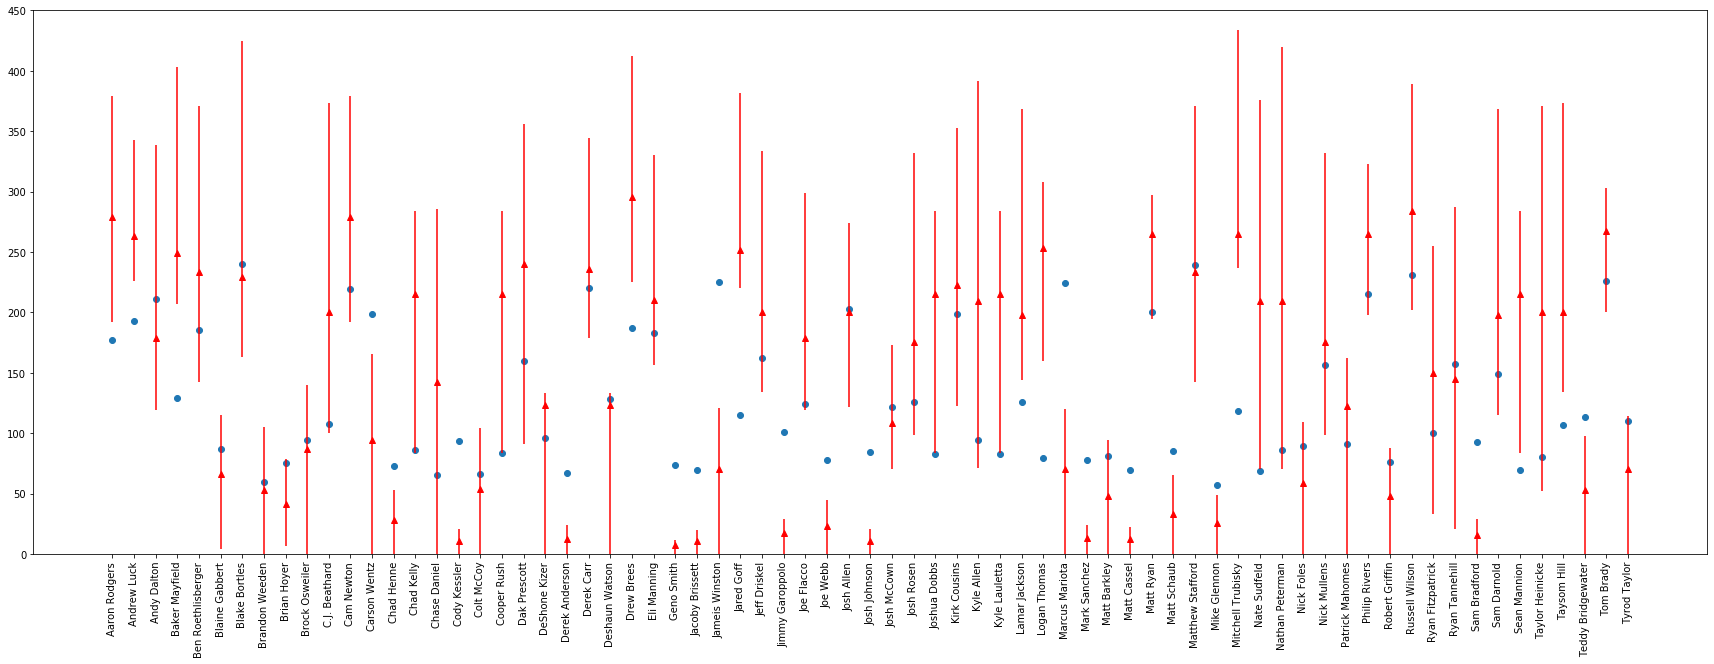

In [138]:
fig, ax = plt.subplots(figsize=(30,10))

plt.errorbar(kd_pred_qb['Name'], kd_pred_qb['point'], np.array([kd_pred_qb['high'] - kd_pred_qb['point'], kd_pred_qb['point']- kd_pred_qb['low']]), fmt='r^')
plt.scatter(ada_pred_qb['Name'], ada_pred_qb['prediction'])
plt.xticks(rotation=90)
plt.ylim([0, 450])
plt.show()

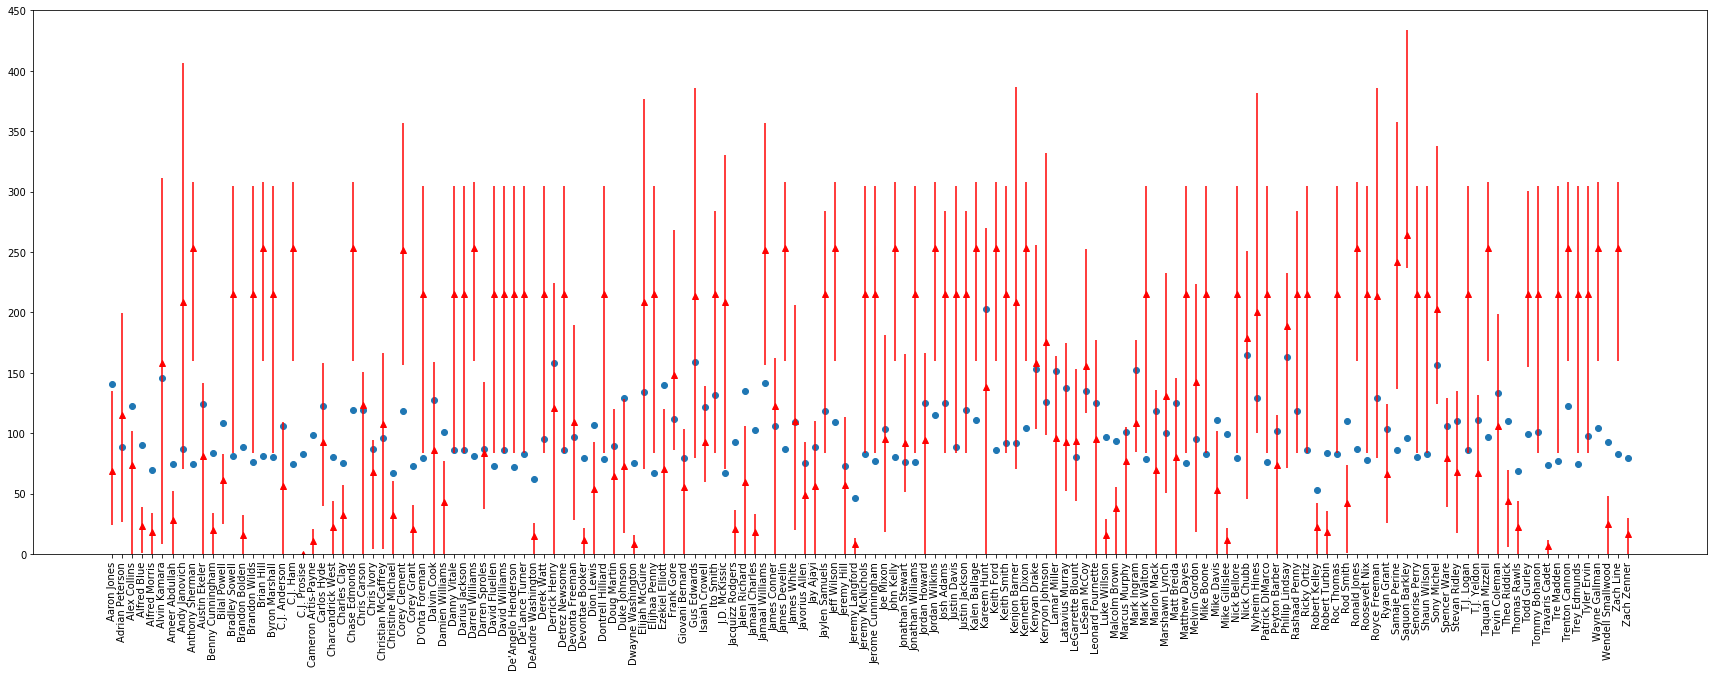

In [139]:
fig, ax = plt.subplots(figsize=(30,10))

plt.errorbar(kd_pred_rb['Name'], kd_pred_rb['point'], np.array([kd_pred_rb['high'] - kd_pred_rb['point'], kd_pred_rb['point']- kd_pred_rb['low']]), fmt='r^')
plt.scatter(ada_pred_rb['Name'], ada_pred_rb['prediction'])

plt.xticks(rotation=90)
plt.ylim([0, 450])

plt.show()

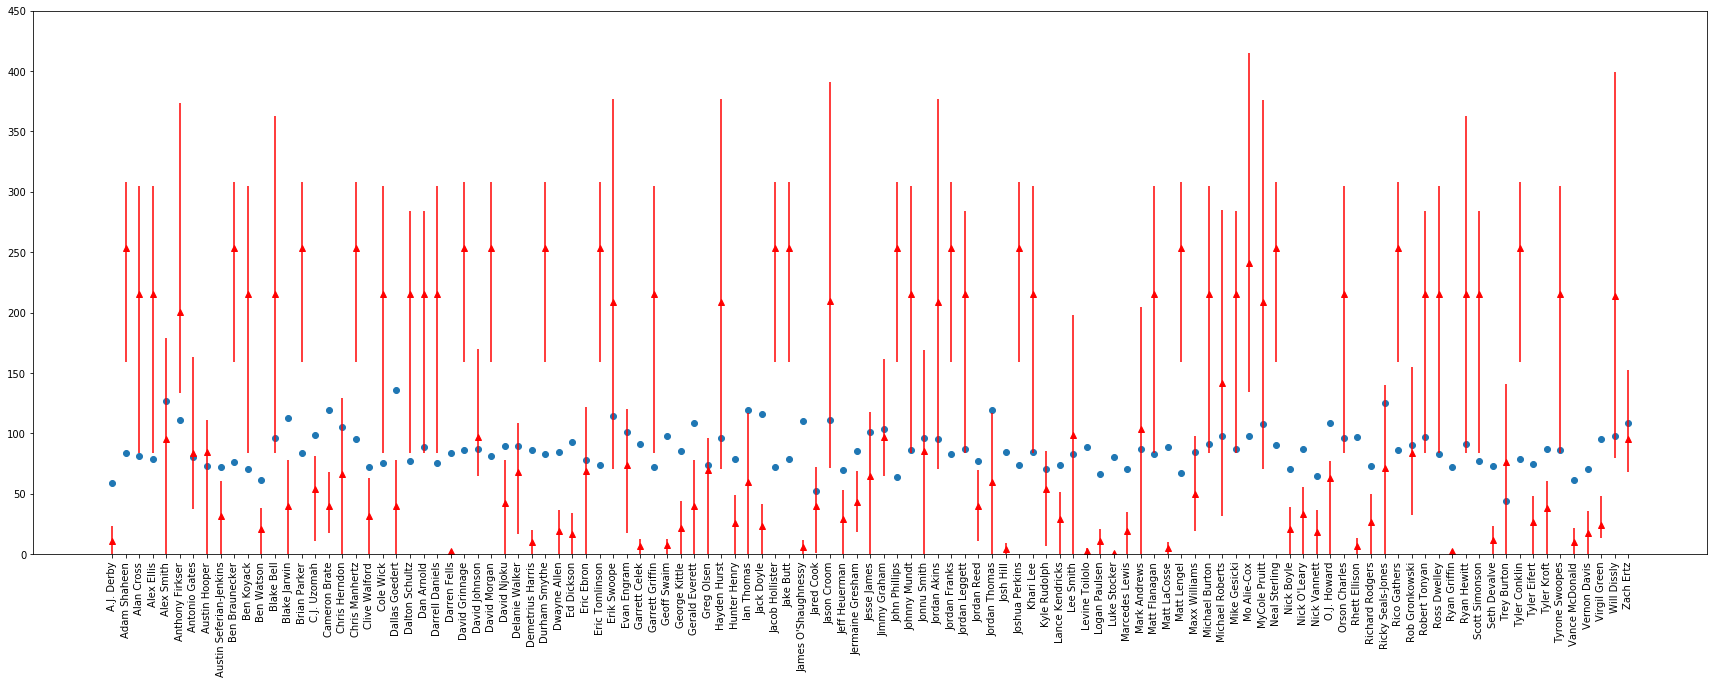

In [140]:
fig, ax = plt.subplots(figsize=(30,10))

plt.errorbar(kd_pred_te['Name'], kd_pred_te['point'], np.array([kd_pred_te['high'] - kd_pred_te['point'], kd_pred_te['point']- kd_pred_te['low']]), fmt='r^')
plt.scatter(ada_pred_te['Name'], ada_pred_te['prediction'])

plt.xticks(rotation=90)
plt.ylim([0, 450])

plt.show()

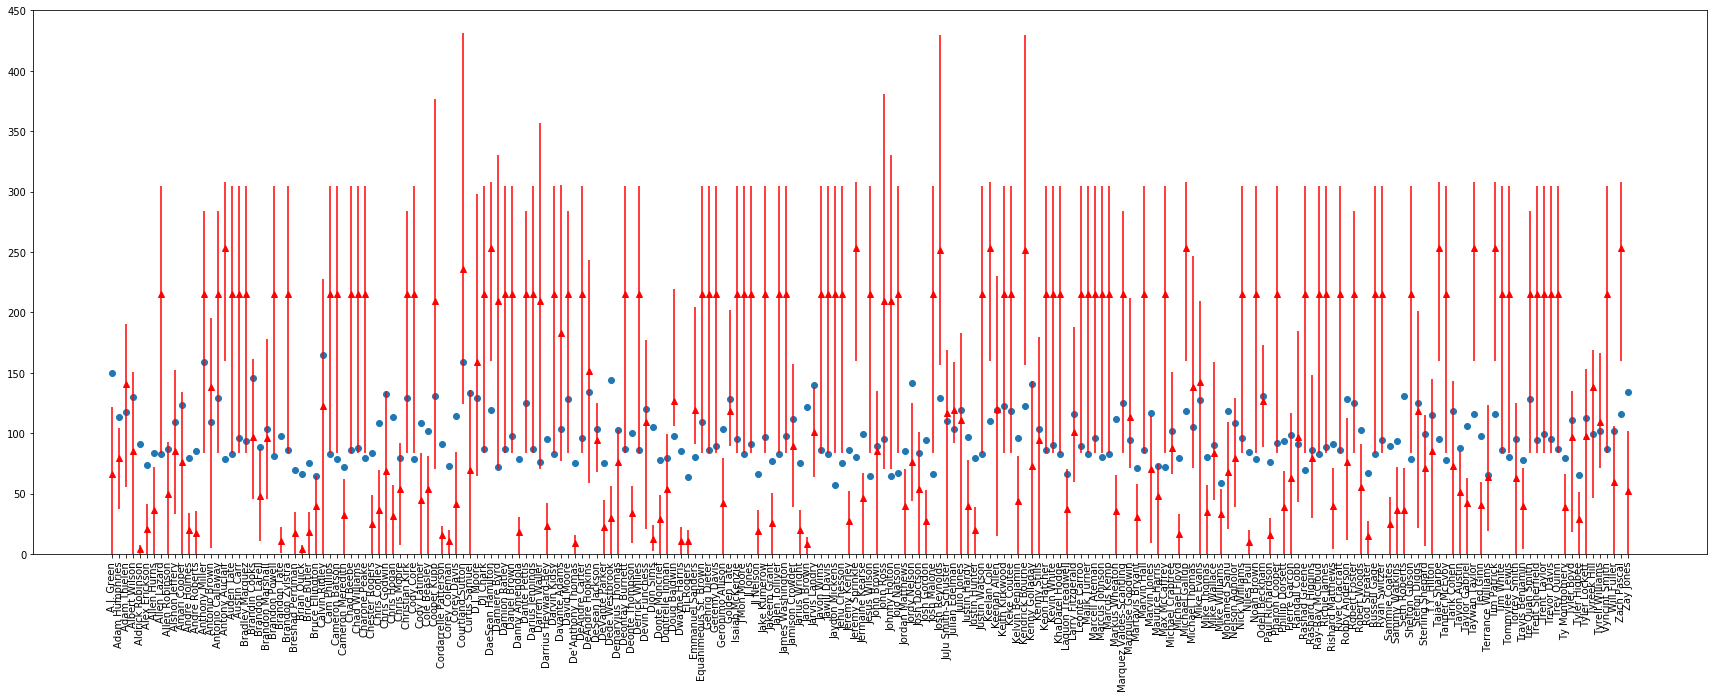

In [141]:
fig, ax = plt.subplots(figsize=(30,10))

plt.errorbar(kd_pred_wr['Name'], kd_pred_wr['point'], np.array([kd_pred_wr['high'] - kd_pred_wr['point'], kd_pred_wr['point']- kd_pred_wr['low']]), fmt='r^')
plt.scatter(ada_pred_wr['Name'], ada_pred_wr['prediction'])

plt.xticks(rotation=90)
plt.ylim([0, 450])

plt.show()

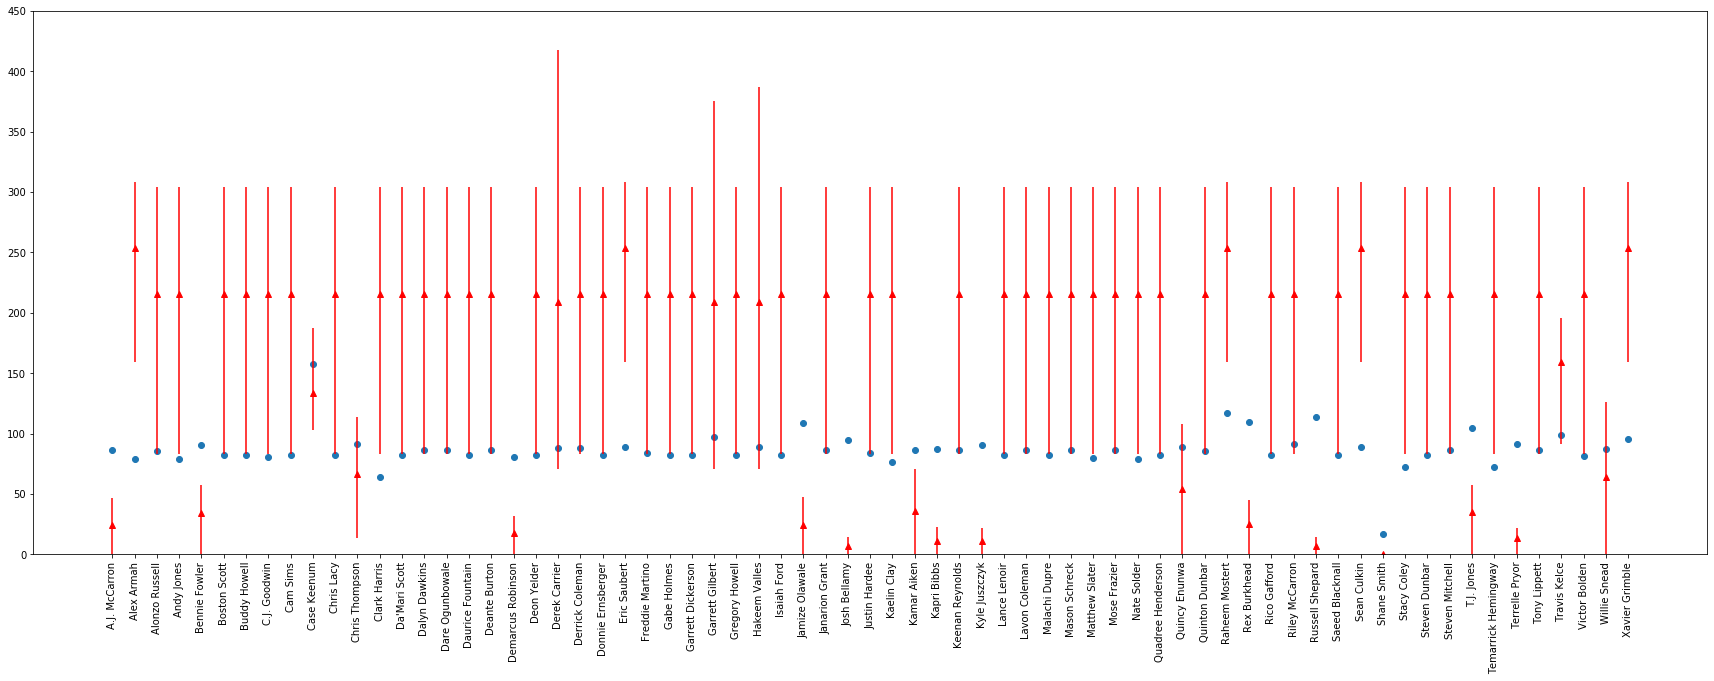

In [142]:


fig, ax = plt.subplots(figsize=(30,10))

plt.errorbar(kd_pred_none['Name'], kd_pred_none['point'], np.array([kd_pred_none['high'] - kd_pred_none['point'], kd_pred_none['point']- kd_pred_none['low']]), fmt='r^')
plt.scatter(ada_pred_none['Name'], ada_pred_none['prediction'])

plt.xticks(rotation=90)
plt.ylim([0, 450])

plt.show()